In [1]:
from Functions import *


In [2]:
''' loop parameters '''
N1 = 60
N2 = 50
f1 = 9.737399163879598
f1_list = np.linspace(-0.05, 0.05, N1)+f1
f0_list = np.linspace(-7.5,7.5,N2)+290.
if_loop = 1			# to loop or not to loop


In [3]:
''' Beam parameters '''
N = 2048			# number of sampling points
E0 = 12665			# photon energy [eV]
tau = 100			# pulse duration [fs]
window = 4000		# total simulation time window [fs]

''' OE parameters '''
hkl = [4,4,0]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}


In [4]:
''' Define beamline '''
crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
							  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)
if alphaAsym <= 0:
	print('\n***\n***\n*** Bragg angle smaller than grazing angle')

f1 = f1
f2 = 10.

devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)


b 1.00
b 1.00
b 9.52
crystal 2 incidence angle: 56.31 degrees
crystal 2 exit angle: 5.01 degrees
b 1.00
b 0.10


In [5]:
''' propagate '''
blockPrint()
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
tfin = time.time()


C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
''' IO '''
path = '../{} eV/'.format(E0)
make_dir(path)

fig_path = path+'/f1_f0_compensation/'
make_dir(fig_path)

hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'compensation_{}_{}keV'.format(
	hkl_, round(beam_params['photonEnergy']/1000.,4))

blockPrint()


In [7]:
%%capture capt
''' loop '''
if if_loop == 1:
    duration = np.zeros((N1,N2))
    tilt = np.zeros_like(duration)
    bw = np.zeros_like(duration)
    throughput = np.zeros_like(duration)
    cent_E = np.zeros_like(duration)
    
    for i, f1_ in enumerate(f1_list):
        for j, f0_ in enumerate(f0_list):
            devices = define_devices(f1_,f2,slit_width = 100e-6, hkl = hkl,
                                 alphaAsym = alphaAsym, E0=E0, f0 = f0_, d23=7.)
            mono_beamline = beamline.Beamline(devices)
            beam_params['photonEnergy'] = E0
            pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
            pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
            centroid, duration[i,j] = pulse.pulse_duration('im2')
            tilt[i,j] = pulse.pulsefront_tilt('im2')
            
            devices = define_devices(f1_,f2,slit_width = 7e-6, hkl = hkl,
                                 alphaAsym = alphaAsym, E0=E0, f0 = f0_, d23=7.)
            mono_beamline = beamline.Beamline(devices)
            beam_params['photonEnergy'] = E0
            pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
            pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
            bw[i,j] = pulse.pulse_bandwidth('im2')
            throughput[i,j] = pulse.throughput('im0','im2')
            cent_E[i,j] = pulse.central_energy('im2')
    if os.path.exists(fig_path+fname+'.h5'):
        os.remove(fig_path+fname+'.h5')
        
    with h5py.File(fig_path+fname+'.h5','w') as f:
        f.create_dataset('f1', data=f1_list)
        f.create_dataset('f0', data=f0_list)
        f.create_dataset('duration', data=duration)
        f.create_dataset('tilt', data=tilt)
        f.create_dataset('bandwidth', data=bw)
        f.create_dataset('throughput', data=throughput)
        f.create_dataset('central_energy', data=cent_E)

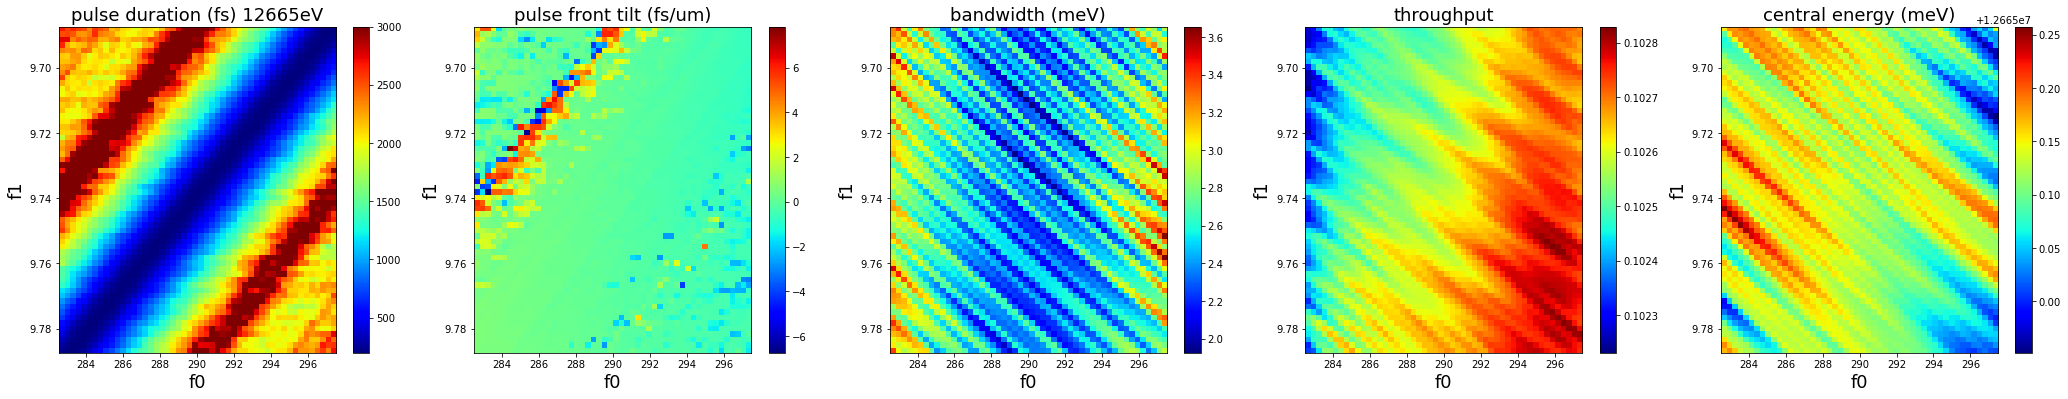

In [13]:
''' plot '''
with h5py.File(fig_path+fname+'.h5','r') as f:
    f1_list = f['f1'][:]
    f0_list = f['f0'][:]
    duration = f['duration'][:]
    tilt = f['tilt'][:]
    bw = f['bandwidth'][:]
    throughput = f['throughput'][:]
    cent_E = f['central_energy'][:]
    
# plots
plt.figure(figsize=(36,6))
plt.subplot(1,5,1)
plt.imshow(duration, cmap='jet',
          extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.clim([duration.min(),3000])
plt.xlabel('f0', fontsize=18)
plt.ylabel('f1', fontsize=18)
plt.axis('tight')
plt.title('pulse duration (fs) {}eV'.format(E0), fontsize=18)

plt.subplot(1,5,2)
plt.imshow(tilt, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0', fontsize=18)
plt.ylabel('f1', fontsize=18)
plt.axis('tight')
plt.title('pulse front tilt (fs/um)', fontsize=18)

plt.subplot(1,5,3)
plt.imshow(bw*1e3, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0', fontsize=18)
plt.ylabel('f1', fontsize=18)
plt.axis('tight')
plt.title('bandwidth (meV)', fontsize=18)

plt.subplot(1,5,4)
plt.imshow(throughput, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0', fontsize=18)
plt.ylabel('f1', fontsize=18)
plt.axis('tight')
plt.title('throughput', fontsize=18)

plt.subplot(1,5,5)
plt.imshow(cent_E*1e3, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0', fontsize=18)
plt.ylabel('f1', fontsize=18)
plt.axis('tight')
plt.title('central energy (meV)', fontsize=18)

plt.savefig(fig_path+fname+'.png')